<a id='summary'></a>
# Spatialization
* Using the Orange OD Matrix as a transition matrix to draw destinations for the census equipped with agendas.
* <font color='red'> **v9**: 
    * proba o is not used
    * transition matrix is differentiated by distance bin, but not by mode
</font>

## Summary
* [Parameters](#parameters)


* [Loading data](#data)
    * [GIS](#gis)
    * [transition_matrices](#od)
    * [synthetic pop](#synthpop) ([Grouping agendas](#Grouping_agendas))
    
    
* [Preparing df to dicts of arrays](#preproc)

* [Functions to query probas](#proba)

* [Running](#running)
    
    
* [Sanity checks](#sanity)
* [Adding empty agendas](#add_empty)
* [Exportation & conclusion](#export)


In [1]:
import datetime
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
import numba
from numba import njit, prange
from numba_progress import ProgressBar
from tqdm import tqdm

from utils.chrono import Chrono
from utils_spatialize.npjoin import npjoin
from utils_spatialize.nptile import nptile
from utils_spatialize.npchoice import npchoice

with open('config.json', 'r') as config_path:
    config = json.load(config_path)

<a id='parameters'></a>
## Spatialisation parameters
* Number of iteration to warmup MCMC with respect to max autonomy of the agenda
* And number of cooldown iterations wrt autonomy
* Recall: the max autonomy of an agenda is the max number of activities that is performed between two `home`
* Agendas with low autonomy are actually several segments of low dimension so don't require a lot of warmup/cooldown
* Note that entry n°0 is never used
* [back to summary](#summary)

In [2]:
nb_warm_iter_dict = np.array(config['nb_warmup_mcmc'])
nb_cooldown_iter_dict = np.array(config['nb_cooldown_mcmc'])

<a id='data'></a>
# Loading data

<a id='gis'></a>
## GIS
* Just to get the nearest neighbours for when agents ask for flows that do not exist in the transition matrix
* [back to summary](#summary)

In [3]:
gis_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['gis_map_filename'])
iris_commune = gpd.read_file(gis_path)

iris_commune = iris_commune.drop(columns=['wkt','geometry', 'is_iris'])

for col in iris_commune.columns:
    iris_commune[col] = iris_commune[col].astype(float)


<a id='od'></a>
## Transition matrices
* <font color='red'> **v9**: transition matrix is not by mode but by distance bins</font>
* [back to summary](#summary)

In [4]:
transition_matrix_path = os.path.join(config['outdata_dir']['path'],
                                      config['outdata_dir']['transition_matrix_by_dist_filename'])
c = Chrono('Loading transition matrix from {}'.format(transition_matrix_path))
trans_matrix = pd.read_csv(transition_matrix_path)
c.write('{} rows'.format(len(trans_matrix)))

c.write('Adding distbin column...')

distbins = np.sort(trans_matrix['dist_bin_min'].unique())
c.write('dist bins: {}'.format(np.concatenate([distbins, [trans_matrix['dist_bin_max'].max()]])))

bin_id_dict = {rmin:i for i, rmin in enumerate(distbins)}
trans_matrix['distbin'] = trans_matrix['dist_bin_min'].replace(bin_id_dict)


c.done()
trans_matrix.head()



17:29:35	Loading transition matrix...
00:00:35	2274789 rows
00:00:35	Adding distbin column...
00:00:36	dist bins: [   0.  200.  500. 1000. 3000. 5000. 7000. 9000.   inf]
00:00:36	Work complete !


,o,d,t,vol,proba_d,cart_key,x_o,y_o,geometry,x_d,y_d,centroid_dist,dist_bin_min,dist_bin_max,distbin
0,1043,1043,0.0,9.132230,1.0,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736276 2535603.293955, 39314...",3.932173e+06,2.538223e+06,0.0,0,200.0,0
1,1043,1043,2.0,5.813602,1.0,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736276 2535603.293955, 39314...",3.932173e+06,2.538223e+06,0.0,0,200.0,0
2,1043,1043,5.0,17.833213,1.0,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736276 2535603.293955, 39314...",3.932173e+06,2.538223e+06,0.0,0,200.0,0
3,1043,1043,7.0,54.360548,1.0,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736276 2535603.293955, 39314...",3.932173e+06,2.538223e+06,0.0,0,200.0,0
4,1043,1043,8.0,29.113536,1.0,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736276 2535603.293955, 39314...",3.932173e+06,2.538223e+06,0.0,0,200.0,0


<a id='synthpop'></a>
## Synthetic population
* [back to summary](#summary)

In [5]:
synthpop_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['synthpop_rescaled_filename'])

c=Chrono('Loading agents from {}'.format(synthpop_path))
synthpop = pd.read_csv(synthpop_path)
c.done()

c.write('{} rows, 1 row per agents'.format(len(synthpop)))

max_chain_len = synthpop['chain_len'].max()
c.write('max_chain_len = {}'.format(max_chain_len))

synthpop.head()

17:30:11	Loading agents from /Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch_rescaleipu.csv
00:00:18	Work complete !
00:00:18	1335786 rows, 1 row per agents
00:00:18	max_chain_len = 10


,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work,id_agenda,dep_0_motif,dep_0_zone,...,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute,agent_id
0,690270102,0,1,8,3,0,-1,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,0
1,69288,0,1,6,1,0,2,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,1
2,69298,0,1,6,2,0,5,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,2
3,692661301,0,1,7,0,0,-1,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,3
4,690890301,0,1,5,2,0,-1,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,4


## Find centroid to centroid distances

In [6]:
# # Problem : some agendas go outside the study zone so we can't get the centroid-to-centroid distance
# 
# zf_path = os.path.join(config['data_dir']['path'], 
#                        config['data_dir']['HTS_gis_filename'])
# zf = gpd.read_file(zf_path).to_crs('epsg:3035')
# 
# zf['ZF2015_Nouveau_codage'] = zf['ZF2015_Nouveau_codage'].astype(float)
# zf['x'] = zf['geometry'].centroid.x
# zf['y'] = zf['geometry'].centroid.y
# gis_coords = zf[['ZF2015_Nouveau_codage', 'x', 'y']]
# gis_coords.head(3)
# 
# print(len(synthpop))
# for i in range(0, max_chain_len+1):
#     synthpop = synthpop.merge(gis_coords.rename(columns={'x':'x_{}'.format(i), 'y':'y_{}'.format(i)}),
#                               left_on='dep_{}_zone'.format(i),
#                              right_on=('ZF2015_Nouveau_codage'),
#                              how='left').drop(columns=['ZF2015_Nouveau_codage'])
#     print(len(synthpop))
#     
# nb_missing_coords = len(synthpop[(synthpop['chain_len']>0) & (synthpop['x_1'].isna())]['dep_1_zone'].unique())
# assert nb_missing_coords==0, "Some zones indicated in the agendas are not in the corresponding GIS !"
# 
# 
# for i in range(1, max_chain_len+1):
#     xprev = synthpop['x_{}'.format(i-1)]
#     yprev = synthpop['y_{}'.format(i-1)]
#     xnext = synthpop['x_{}'.format(i)]
#     ynext = synthpop['y_{}'.format(i)]
#     synthpop['dep_{}_centroid_dist'.format(i)] = np.sqrt((xprev-xnext)**2+(yprev-ynext)**2)
#     
#     
#     
# for i in range(1, max_chain_len+1):
#     synthpop['dep_{}_distbin'.format(i)] = pd.cut(synthpop['dep_{}_l2'.format(i)], 
#                                                   bins=np.concatenate([distbins,[np.inf]]), 
#                                                    include_lowest=True,
#                                                   labels=range(len(distbins))).astype(float)
#     
#     
# # ensuring we have a distance specified for all trips of each agenda
# l2_col_names = ['dep_{}_centroid_dist'.format(i) for i in range(1, max_chain_len+1)]
# nb_wrongs = ((~np.isnan(synthpop[l2_col_names].values)).sum(axis=1) != synthpop['chain_len']).sum()
# assert nb_wrongs == 0, '{} agendas have missing distances'.format(nb_wrongs)
# 
# # ensuring we have a dist bin specified for all trips of each agenda
# distbin_col_names = ['dep_{}_distbin'.format(i) for i in range(1, max_chain_len+1)]
# wrong_nb_of_distbins_mask = (~np.isnan(synthpop[distbin_col_names].values)).sum(axis=1) != synthpop['chain_len']
# assert wrong_nb_of_distbins_mask.sum() == 0

#### viz

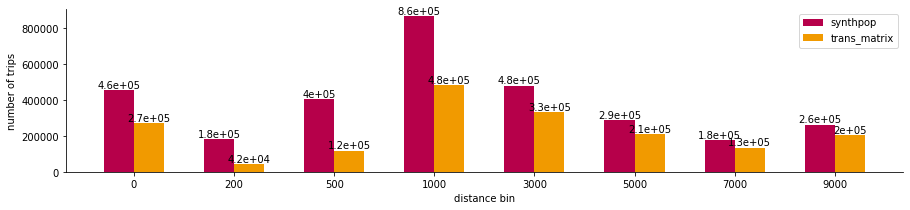

In [7]:
from utils.comp_bar import comp_bar


synthpop_bin_counts = (pd.concat([synthpop.groupby('dep_{}_distbin'.format(i)).size() 
                                  for i in range(1, max_chain_len+1)])
                       .reset_index().groupby('index').sum()[0])

trans_matrix_bin_counts = trans_matrix.groupby('distbin')['vol'].sum()


fig, ax = plt.subplots(figsize=(15, 3))

comp_bar(ax, bars=[synthpop_bin_counts, trans_matrix_bin_counts],
             colors=((182/255,0/255,74/255), (241/255, 154/255, 0/255)),
             bar_labels=['synthpop', 'trans_matrix'],
             width=0.3,
            #normalize=True
        )

ax.set_xticks(np.arange(len(trans_matrix_bin_counts)),distbins)
ax.set_xlabel('distance bin')
ax.set_ylabel('number of trips')
plt.show()

<a id='Grouping_agendas'></a>
### Grouping agendas
* Agendas are considered equivalent if they share the same activity chain and the same home zone.
* Note that we could broaden the equivalence because the exact secondary purposes do not impact the spatialisation.
* But it doesn't change a lot actually.
* [back to summary](#summary)

In [8]:
c=Chrono('Grouping agendas...')
synthpop['id_agent'] = np.arange(len(synthpop))

agenda_cols = ['dep_0_motif'] + ['dep_{}_{}'.format(i, carac) for i in range(1, max_chain_len+1) 
               for carac in ['motif', 'time', 'distbin']]


synthpop_grouped = (synthpop[(synthpop['chain_len']>0) & (synthpop['autonomy']>0)]
                                # note that the fist condition should be enough
                    .groupby(agenda_cols+['iris_or_commune'], dropna=False)
                    .agg({'chain_len':'first',
                          'gender'   :'count',
                          'autonomy' :'first',
                          'id_agent' : list})
                    .rename(columns={'gender':'vol'}).reset_index())

synthpop_empty_agenda = synthpop.loc[(synthpop['chain_len']==0) | (synthpop['autonomy']==0)].copy()

c.write('{} distinct agendas'.format(len(synthpop_grouped)))
c.write('{} agents out of {} ({:.2%}%) have empty agendas, we don\'t spatialise them '
        'and they have to be added at the end'.format(len(synthpop_empty_agenda), len(synthpop),
                                                     len(synthpop_empty_agenda)/len(synthpop)))
c.done()



17:30:30	Grouping agendas...
00:00:28	569280 distinct agendas
00:00:28	283041 agents out of 1335786 (21.19%%) have empty agendas, we don't spatialise them and they have to be added at the end
00:00:28	Work complete !


<a id='preproc'></a>
# Preparing df to dicts of arrays


* we transform all pd.DataFrame to np.array, so we have to keep track of the numbering of the columns
* <font color='red'>**v9:**     </font>
    * <font color='red'>no mode cols</font>
    * <font color='red'>there are distance bin cols instead</font>

* [back to summary](#summary)

### making sure we find the right columns

In [9]:

trans_matrix_arr = trans_matrix[['o', 'd', 't', 'proba_d', 'distbin']].values
#trans_matrix_arr = trans_matrix[['o', 'd', 't', 'vol', 'distbin']].values
o_col, d_col, t_col, probad_col, b_col = 0, 1, 2, 3, 4

max_neighbor_rank = 20
neighbor_cols = ['nearest_neighbor_{}'.format(i) for i in range(max_neighbor_rank)]
iris_commune_arr = iris_commune[['iris_or_commune'] + neighbor_cols].values
z_col, neighbor_0_col = 0, 1

motif_col_names = ['dep_{}_motif'.format(i) for i in range(max_chain_len+1)]
motif_cols = np.arange(len(motif_col_names), dtype=int)

time_col_names = ['dep_{}_time'.format(i) for i in range(1, max_chain_len+1)]
time_cols = np.arange(len(motif_col_names), len(motif_col_names)+len(time_col_names), dtype=int)

distbin_col_names = ['dep_{}_distbin'.format(i) for i in range(1, max_chain_len+1)]
distbin_cols = np.arange(len(motif_col_names)+len(time_col_names), 
                          len(motif_col_names)+len(time_col_names)+len(distbin_col_names), dtype=int)

chain_len_col = len(motif_cols) + len(time_cols) + len(distbin_cols)
home_col = chain_len_col + 1
vol_col = home_col + 1
autonomy_col = vol_col + 1

### ztb_to_i
* we slice our arrays into numba dicts but tuples are not accepted as keys in numba dicts
* <font color='red'>**v9:** 
    * no mode
    * there is a distance bin instead
</font>
* [back to summary](#summary)

In [10]:
@njit
def ztb_to_i(z,t,b):
    """tuples (z,t,b) are not accepted as keys in numba dicts"""
    return z*1000+t*10+b

### `create_trans_matrix_d_dict_numba`
* transforming the transition matrix to dicts:
* `d_list_dict`: dict of (origin, timestep, distance_bin): list of each possible destination
* `proba_d_dict`: dict of (origin, timestep, distance_bin): list of probas for each possible destination
* [back to summary](#summary)

In [11]:
timesteps = trans_matrix['t'].unique()
from numba.typed import Dict
from numba.core import types

float_array = types.float64[:]
float_type = types.float64

def create_trans_matrix_d_dict_numba(trans_matrix_arr):
    
    # Make dictionary
    d_list_dict = Dict.empty(
        key_type=float_type,
        value_type=float_array,
    )
    proba_d_dict = Dict.empty(
    key_type=float_type,
    value_type=float_array
    )
    
    for o in tqdm(np.unique(trans_matrix_arr[:,o_col])):
        trans_matrix_sub_o = trans_matrix_arr[(trans_matrix_arr[:, o_col]==o)]
        for t in timesteps:
            trans_matrix_sub_ot = trans_matrix_sub_o[(trans_matrix_sub_o[:, t_col]==t)]
            for b in range(len(distbins)):
                trans_matrix_sub = trans_matrix_sub_ot[(trans_matrix_sub_ot[:,b_col]==b)].astype(np.float64)

                k = ztb_to_i(o,t,b)
                sort_ind = np.argsort(trans_matrix_sub[:,d_col])
                
                d_list_dict[k] = trans_matrix_sub[sort_ind, d_col]
                proba_d_dict[k] = trans_matrix_sub[sort_ind, probad_col]
        

    return d_list_dict, proba_d_dict


d_list_dict, proba_d_dict = create_trans_matrix_d_dict_numba(trans_matrix_arr)
    

100%|█████████████████████████████████████████| 536/536 [00:10<00:00, 51.75it/s]


### `create_trans_matrix_o_dict_numba`
* transforming the transition matrix to dicts:
* `o_list_dict`: dict of (destination, timestep, distance_bin): list of each possible origin
* `proba_o_dict`: dict of (destination, timestep, distance_bin): list of probas $P(d|o,t)$ for each possible origin
* [back to summary](#summary)

In [12]:

def create_trans_matrix_o_dict_numba(trans_matrix_arr):
    """
    gives P(d|o,t,b) for all o
    """
    # numba-fication of this does makes the notebook stop responding
    
    # Make dictionary
    o_list_dict = Dict.empty(
        key_type=float_type,
        value_type=float_array,
    )
    proba_o_dict = Dict.empty(
    key_type=float_type,
    value_type=float_array
    )
    
    for d in tqdm(np.unique(trans_matrix_arr[:,d_col])):
        trans_matrix_sub_d = trans_matrix_arr[(trans_matrix_arr[:, d_col]==d)]
        for t in timesteps:
            trans_matrix_sub_dt = trans_matrix_sub_d[(trans_matrix_sub_d[:, t_col]==t)]
            for b in range(len(distbins)):
                trans_matrix_sub = trans_matrix_sub_dt[(trans_matrix_sub_dt[:,b_col]==b)].astype(np.float64)

                k = ztb_to_i(d,t,b)
                sort_ind = np.argsort(trans_matrix_sub[:,o_col])
                
                o_list_dict[k] = trans_matrix_sub[sort_ind, o_col]
                
                # note that sum(p(d|o,t)) over all o is not 1 but we normalize after.
                proba_o_dict[k] = trans_matrix_sub[sort_ind, probad_col]
        
    return o_list_dict, proba_o_dict


o_list_dict, proba_o_dict = create_trans_matrix_o_dict_numba(trans_matrix_arr)
    

100%|█████████████████████████████████████████| 536/536 [00:09<00:00, 56.51it/s]


<a id='proba'></a>
# Functions to query probas

### `up_and_down_explore`
* To explore the other distbins when there is no trip found in the transition matrix for a particular (origin, timestep, distbin)
* We explore first the demanded distbin, then the one above, then below, then 2 above, then 2 below...
* We save this order in a dictionnary so we don't have to recompute it each time

In [13]:
from utils_spatialize.up_and_down_explore import up_and_down_explore
    
distbins_paths = Dict.empty(key_type=float_type, value_type=float_array)

print('Exploring all indices between 0 and {}'.format(len(distbins)-1))
for d in range(len(distbins)):
    print('Starting at {}: {}'.format(d, up_and_down_explore(d,0,len(distbins))))
    distbins_paths[d] = up_and_down_explore(d,0,len(distbins))


Exploring all indices between 0 and 7
Starting at 0: [0. 1. 2. 3. 4. 5. 6. 7.]
Starting at 1: [1. 2. 0. 3. 4. 5. 6. 7.]
Starting at 2: [2. 3. 1. 4. 0. 5. 6. 7.]
Starting at 3: [3. 4. 2. 5. 1. 6. 0. 7.]
Starting at 4: [4. 5. 3. 6. 2. 7. 1. 0.]
Starting at 5: [5. 6. 4. 7. 3. 2. 1. 0.]
Starting at 6: [6. 7. 5. 4. 3. 2. 1. 0.]
Starting at 7: [7. 6. 5. 4. 3. 2. 1. 0.]


### `get_proba_o` and `get_proba_d`

* [back to summary](#summary)

In [14]:

@njit
def get_proba_o(o_list_dict, proba_o_dict, d, t, b):
    """
    return proba of each o given d, t, b
    d: destination
    t: timestep
    b: distance bin
    
    If no origin exist for this (d,t,b), look into the nearest neighbor of d
    iteratively as long as we didn't exhaust the list of nearest neighbors.
    """
    key = ztb_to_i(d,t,b)
    o_list = o_list_dict.get(key)
    
    # getting the transitions from nearest zone instead
    if (o_list is None) or (len(o_list)==0):
        neighbor_col = neighbor_0_col
        z_row = iris_commune_arr[iris_commune_arr[:, z_col]==d]
        while (neighbor_col<z_row.shape[1]) and ((o_list is None) or (len(o_list)==0)) :
            nn = z_row[:, neighbor_col].item()
            key = ztb_to_i(nn,t,b)
            o_list = o_list_dict.get(key)
            neighbor_col += 1
        if neighbor_col==z_row.shape[1]:
            return np.empty(shape=0), np.empty(shape=0)
            # raise ValueError('Asked for all the neighbors but no transition found going to (d,t,b)=({:.0f},{:.0f},{:.0f})'.format(d,t,b))
            
    proba_o = proba_o_dict[key]
    
    return o_list, proba_o


@njit
def get_proba_o_binsearch(row, locations, o_list_dict, proba_o_dict, 
                            dim, time_cols, distbin_cols, distbins_paths):
    """
    additional layer to search proba_o when nothing in the target distance bin is found
    """
    
    time_col = time_cols[dim]
    distbin_col = distbin_cols[dim]
    distbins_to_explore = distbins_paths[row[distbin_col]]
    
    for distbin in distbins_to_explore:
        o_list, proba_o = get_proba_o(o_list_dict, proba_o_dict,
                          locations[dim+1],  # destination
                          row[time_col], # curr timestep
                          distbin,
                         )
        if len(o_list)>0:
            return o_list, proba_o

@njit
def get_proba_d(d_list_dict, proba_d_dict, o, t, b):
    """
    return proba of each d given o, t, b
    o: origin
    t: timestep
    b: distance bin
    
    If no destination exist for this (o,t,b), look into the nearest neighbor of o
    iteratively as long as we didn't exhaust the list of nearest neighbors.
    """
    key = ztb_to_i(o,t,b)
    d_list = d_list_dict.get(key)
    
    # getting the transitions from nearest zone instead
    if d_list is None or len(d_list)==0:
        neighbor_col = neighbor_0_col
        z_row = iris_commune_arr[iris_commune_arr[:, z_col]==o]
        while (neighbor_col<z_row.shape[1]) and ((d_list is None) or (len(d_list)==0)):
            nn = z_row[:, neighbor_col].item()
            key = ztb_to_i(nn,t,b)
            d_list = d_list_dict.get(key)
            neighbor_col += 1
        if neighbor_col==z_row.shape[1]:
            return np.empty(shape=0), np.empty(shape=0)         
        #    raise ValueError('Asked for all the neighbors but no transition found starting from (o,t,b)=({:.0f},{:.0f},{:.0f})'.format(o,t,b))
            
    proba_d = proba_d_dict[key]
    return d_list, proba_d


@njit
def get_proba_d_binsearch(row, locations, d_list_dict, proba_d_dict, 
                            dim, time_cols, distbin_cols, distbins_paths):
    """
    additional layer to search proba_d when nothing in the target distance bin is found
    """
    time_prev_col = time_cols[dim-1]
    distbin_prev_col = distbin_cols[dim-1]
    
    distbins_to_explore_prev = distbins_paths[row[distbin_prev_col]]
    for distbin in distbins_to_explore_prev:
        d_list, proba_d = get_proba_d(d_list_dict, proba_d_dict,
                              locations[dim-1], # origin
                              row[time_prev_col], # prev timestep
                              distbin,
                             )
        if len(d_list)>0:
            return d_list, proba_d

### `get_proba_z`
* is proportional to `proba_o` * `proba_d`
* Is used if the location `z` has no linked states.
* [back to summary](#summary)

In [15]:
@njit
def join_odz(o_list, proba_o, d_list, proba_d, eps=1e-10):
    """joining proba of o with proba of d"""
    z_arr = npjoin(o_list, proba_o, d_list, proba_d, eps)
    z_list = z_arr[:,0]
    
    new_probao_col = 1
    new_probad_col = 2
    proba_z = z_arr[:, new_probao_col] * z_arr[:, new_probad_col]
    return z_list, proba_z
    
@njit
def get_proba_z(row, locations, o_list_dict, proba_o_dict, 
                                d_list_dict, proba_d_dict, 
                dim, time_cols, distbin_cols, distbins_paths):
    
    if dim==0:  # first place may not be home
        z_list, proba_z = get_proba_o_binsearch(row, locations, o_list_dict, proba_o_dict, 
                            dim, time_cols, distbin_cols, distbins_paths)

    elif dim==len(locations)-1:  # last place may not be home
        z_list, proba_z = get_proba_d_binsearch(row, locations, d_list_dict, proba_d_dict, 
                            dim, time_cols, distbin_cols, distbins_paths)

    else:
        o_list, proba_o = get_proba_o_binsearch(row, locations, o_list_dict, proba_o_dict, 
                            dim, time_cols, distbin_cols, distbins_paths)
        d_list, proba_d = get_proba_d_binsearch(row, locations, d_list_dict, proba_d_dict, 
                            dim, time_cols, distbin_cols, distbins_paths)
        
        z_list, proba_z = join_odz(o_list, proba_o, d_list, proba_d, eps=1e-10)

    return z_list, proba_z


## Taking linksets into account
* A location Z depends on the previous location, on the next, and on the previous and next of all the activities that have the same primary purpose

In [16]:
@njit
def get_link_mask(purpose_row):
    """
    input : a list of activity purposes
    return : a list of ids for linksets. 
        Activities belonging to the same linkset are expected to have the same location.
    """
    linkset_ids = np.zeros(shape=len(purpose_row), dtype=np.int32)
    max_state_id = 0
    purpose_visited = -np.ones(len(purpose_row))  # stash list
    purpose_to_id = -np.ones(len(purpose_row))  # dict list
    for i, p in enumerate(purpose_row.astype(np.int32)):
        if p in purpose_visited:
            linkset_ids[i] = purpose_to_id[p]
        else:
            if (p>=0) and (p<=2):  # home, work or study
                purpose_visited[max_state_id] = p
                purpose_to_id[p] = max_state_id
                linkset_ids[i] = max_state_id
                max_state_id += 1
            else:
                linkset_ids[i] = max_state_id
                max_state_id += 1
    return linkset_ids

@njit
def get_non_singleton_linksets(link_mask):
    return np.array([i for i in np.unique(link_mask) if (link_mask==i).sum()>1])

purposes_example = np.array([0.,2.,2.,3.,0.])
print('activity purposes: {}'.format(purposes_example))
lm = get_link_mask(purposes_example)
print('link sets : {}'.format(lm))
print('activities appearing more than once: {}'.format(get_non_singleton_linksets(lm)))

activity purposes: [0. 2. 2. 3. 0.]
link sets : [0 1 1 2 0]
activities appearing more than once: [0 1]


In [17]:

@njit
def get_proba_z_linked(row, locations, o_list_dict, proba_o_dict, 
                           d_list_dict, proba_d_dict, 
                            dim, time_cols, distbin_cols, chain_len, distbins_paths):
    """
    get_proba_z but handles the linked states.
    /!\ Assumes linked states NEVER follow each others.
    """
    link_mask = get_link_mask(row[:chain_len])
    non_singleton_linksets = get_non_singleton_linksets(link_mask)

    if link_mask[dim] in non_singleton_linksets:
        #dict (neighboring linkset):(id of each possible zone for current linkset)
        list_linkset_dict = Dict.empty(key_type=types.int32, value_type=float_array)

        #dict (neighboring linkset):(proba of each possible zone for current linkset)
        proba_linkset_dict = Dict.empty(key_type=types.int32, value_type=float_array)
        
        # number of factors in common with each linkset
        exponant_linksets = np.zeros(link_mask.max()+1)

        for dim_linked in np.where(row[:chain_len]==row[dim])[0]:
            #print(dim_linked)
            if dim_linked<chain_len-1:
                #print('getting proba_o')
                o_list_linked, proba_o_linked = get_proba_o_binsearch(row, locations, o_list_dict, proba_o_dict, 
                                    dim_linked, time_cols, distbin_cols, distbins_paths)

                #print(o_list_linked)
                next_purpose = link_mask[dim_linked+1]
                exponant_linksets[next_purpose] += 1
                if next_purpose in proba_linkset_dict:
                    res_list, proba_res = join_odz(list_linkset_dict[next_purpose], 
                                                   proba_linkset_dict[next_purpose],
                                                   o_list_linked, 
                                                   proba_o_linked)
                    list_linkset_dict[next_purpose] = res_list
                    proba_linkset_dict[next_purpose] = proba_res
                else:
                    list_linkset_dict[next_purpose] = o_list_linked
                    proba_linkset_dict[next_purpose] = proba_o_linked
                    
            if dim_linked>0:
                #print('getting proba_d')
                d_list_linked, proba_d_linked = get_proba_d_binsearch(row, locations, d_list_dict, proba_d_dict, 
                                    dim_linked, time_cols, distbin_cols, distbins_paths)

                #print(d_list_linked)
                prev_purpose = link_mask[dim_linked-1]
                exponant_linksets[prev_purpose] += 1
                if prev_purpose in proba_linkset_dict:
                    res_list, proba_res = join_odz(list_linkset_dict[prev_purpose], 
                                                   proba_linkset_dict[prev_purpose],
                                                   o_list_linked, 
                                                   proba_o_linked)
                    list_linkset_dict[prev_purpose] = res_list
                    proba_linkset_dict[prev_purpose] = proba_res
                else:
                    list_linkset_dict[prev_purpose] = d_list_linked
                    proba_linkset_dict[prev_purpose] = proba_d_linked
                    #print(proba_linkset_dict)
                    
            # count double transitions that we see in factor graphs
            # (a bit optional, doesn't change much the result anyway)
            if (dim_linked+2<len(link_mask)) and (link_mask[dim_linked+2]==link_mask[dim_linked]):
                if dim_linked>0 and (link_mask[dim_linked-1]==link_mask[dim_linked+1]):
                    exponant_linksets[next_purpose] += 1
                    res_list, proba_res = join_odz(list_linkset_dict[next_purpose], proba_linkset_dict[next_purpose],
                                               o_list_linked, proba_o_linked)
                    list_linkset_dict[next_purpose] = res_list
                    proba_linkset_dict[next_purpose] = proba_res
                    
            if (dim_linked-2>=0) and (link_mask[dim_linked-2]==link_mask[dim_linked]):
                if dim_linked+1<len(link_mask) and (link_mask[dim_linked-1]==link_mask[dim_linked+1]):
                    exponant_linksets[prev_purpose] += 1
                    res_list, proba_res = join_odz(list_linkset_dict[prev_purpose], proba_linkset_dict[prev_purpose],
                                               o_list_linked, proba_o_linked)
                    list_linkset_dict[prev_purpose] = res_list
                    proba_linkset_dict[prev_purpose] = proba_res
            #####
            
        z_list, proba_z = np.zeros(shape=0), np.zeros(shape=0)
        for i in range(len(exponant_linksets)):
            if exponant_linksets[i]>0:
                proba_linkset_dict[i] = np.power(proba_linkset_dict[i], 1/exponant_linksets[i])
                z_list, proba_z = join_odz(list_linkset_dict[i], proba_linkset_dict[i], z_list, proba_z)

    else: # linkset is singleton

        z_list, proba_z = get_proba_z(row, locations, o_list_dict, proba_o_dict, 
                                d_list_dict, proba_d_dict, 
                dim, time_cols, distbin_cols, distbins_paths)

        # if prev and next dims are in the same linkset:
        if dim>0 and dim<chain_len-1 and (row[dim-1]==row[dim+1]) and (row[dim-1]>=0) and (row[dim-1]<=2):
            proba_z = np.sqrt(proba_z)

    return z_list, proba_z

<a id='running'></a>
# Running spatialisation
* [back to summary](#summary)

In [18]:
int_type = types.int8
int_array = types.int8[:]

#@njit(parallel=True)
def spatialize(synthpop_grouped_sub_arr, nb_warm_iter_dict, nb_cooldown_iter_dict, 
              o_list_dict, proba_o_dict, d_list_dict, proba_d_dict, distbins_paths,
              progress_proxy
              ):
    locations_sampled = np.zeros(shape=(int(synthpop_grouped_sub_arr[:, vol_col].sum()), max_chain_len+1))
    cum_vols = synthpop_grouped_sub_arr[:, vol_col].cumsum()

    #nb_distbin_search_arr = np.zeros(shape=len(locations_sampled))
    #nb_good_distbin_arr = np.zeros(shape=len(locations_sampled))
    #nb_distbin_search_tot = 0
    #nb_good_distbin_tot = 0
        
        
    
    #for irow in prange(len(synthpop_grouped_sub_arr)):
    for irow in range(len(synthpop_grouped_sub_arr)):
        row = synthpop_grouped_sub_arr[irow]
        # Getting max autonomy of segments of the agenda
        autonomy = int(row[autonomy_col])
        nb_iter = int(nb_warm_iter_dict[autonomy]+row[vol_col]*(nb_cooldown_iter_dict[autonomy] + 1))
    
        chain_len = int(row[chain_len_col]+1)  # chain_len_col should be called nb_trips_col

        locations = np.random.choice(a=iris_commune_arr[:, z_col], size=(chain_len))
        
        # first cols are about motive
        home_mask = (row[:chain_len]==0)

        #Try something smart to not have to browse the entire agenda each time we want to fetch linked states:
        #link_dict = Dict.empty(key_type=int_type, value_type=int_array)
        #for i, motive in enumerate(row[:chain_len]):
        #    if i not in link_dict:
        #        if motive==1 or motive==2:
        #            link_dict[i] = np.where(row[:chain_len]==motive)[0].astype(np.int8)
        #        elif motive != 0:
        #            link_dict[i] = i
        
        locations[home_mask] = row[home_col]

        draw_mask = ~home_mask
        draw_indices = draw_mask.nonzero()[0] # indices we will have to draw in MCMC


        # Sampling each dimension in order, this way we make sure all segments are drawn 
        # One iteration is drawing all states that have to be drawn, in order.
        # We could take a random order but then we wouldn't be sure that all states have been drawn
        # in long segments for chains that have a long segment and a short one.
        dim_to_draw = nptile(draw_indices, nb_iter)

        # i_sample: index of where we save the trajectory we draw in locations_sampled.
        # Each trajectory can concern several agents, so we may have to sample it more than once.
        # So each trajectory has an assigned slot for the first sample, and the following samples
        # are saved in the follow rows.
        if irow==0:
            i_sample=0
        else:
            i_sample = int(cum_vols[irow-1])

        for i, dim in enumerate(dim_to_draw):
            z_list, proba_z = get_proba_z_linked(row, locations, 
                                                                                     o_list_dict, proba_o_dict, 
                                                                                     d_list_dict, proba_d_dict, 
                                                  dim, time_cols, distbin_cols, chain_len, distbins_paths)
            
            
            proba_z = proba_z/proba_z.sum()
            tirage = npchoice(z_list, proba_z)

            if row[dim]==1 or row[dim]==2:
                for linked_dim in np.where(row[:chain_len]==row[dim])[0]:
                    locations[linked_dim] = tirage
            else:
                locations[dim] = tirage
            
            #print('dim {} : {}'.format(dim, tirage))
            ## Sampling once as soon as we finished warmup, and once each time the cooldown is finished
            if ((i>=nb_warm_iter_dict[autonomy]*len(draw_indices)) and 
             (i-len(draw_indices)*nb_warm_iter_dict[autonomy]) % (len(draw_indices)*(nb_cooldown_iter_dict[autonomy] + 1)) == 0):
                locations_sampled[i_sample, :chain_len] = locations
                
                #nb_distbin_search_arr[i_sample] = nb_distbin_search
                #nb_good_distbin_arr[i_sample] = nb_good_distbin
                
                i_sample+=1
                # i_sample+=1 should prbly be replaced by something like:
                # i_sample = int(cum_vols[irow-1]) + (i-len(draw_indices)*nb_warm_iter_dict[autonomy]) // (len(draw_indices)*(nb_cooldown_iter_dict[autonomy] + 1))
                
        progress_proxy.update(1)

    return locations_sampled


In [19]:
# got a parallelization bug that gives us empty agendas for the ones that are not the first of their groups
# so ugly hack while I debug it
# edit: probably it's the line i_sample+=1 that bugs in parallelisation

synthpop_grouped_sub = synthpop_grouped.explode('id_agent')
synthpop_grouped_sub['vol']=1

synthpop_grouped_sub_arr = (synthpop_grouped_sub[motif_col_names+
                                                time_col_names+
                                                distbin_col_names+
                                                ['chain_len', 
                                                 'iris_or_commune',
                                                 'vol',
                                                 'autonomy']]#.sample(frac=0.01)
                                        .values)

In [20]:


c=Chrono('Running...')
with ProgressBar(total=len(synthpop_grouped_sub_arr)) as progress:
    locations_sampled = spatialize(synthpop_grouped_sub_arr, 
                                   nb_warm_iter_dict, 
                                   nb_cooldown_iter_dict,
                                   o_list_dict, proba_o_dict, 
                                   d_list_dict, proba_d_dict, 
                                   distbins_paths,
                                   progress
                                  )

#c.write('Saving...')
#np.savetxt('../../outdata/location_sampled_v9h6.csv', locations_sampled)
#c.done()


17:31:30	Running...


  0%|                                               | 0/1052745 [00:00<?, ?it/s]

/var/folders/4m/96kct6fd1vl7ty8sc_mpj7kw0000gp/T/ipykernel_14327/192134969.py:85: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  proba_linkset_dict[i] = np.power(proba_linkset_dict[i], 1/exponant_linksets[i])
/opt/miniconda3/lib/python3.9/site-packages/numba_progress/progress.py:104: RuntimeWarning: overflow encountered in ulong_scalars
  diff = value - self._last_value


05:22:51	Saving...
05:23:03	Work complete !


<a id='sanity'></a>
# Sanity checks
* [back to summary](#summary)

### Locations exist in gis

In [21]:
gis = np.concatenate([iris_commune['iris_or_commune'].values, [0]])
bad_location_mask = ~np.isin(locations_sampled, gis)
assert bad_location_mask.sum() == 0

### No trajectory has failed to be attributed something

In [22]:
assert np.all(locations_sampled==0,axis=1).sum()==0, 'some locations are set to 0'

* Right amount of chains of each len. 
* **Note:** Offset of 1 in chain_len is explained because `locations_sampled` also has a column for the location 0.

In [23]:
print('Distribution of chain_len in synthpop:\n')
print(synthpop.groupby('chain_len').size())
print('\nDistribution of len of location chains sampled:')
chain_len_locations = np.sum((locations_sampled!=0),axis=1)
print(pd.DataFrame({'nb_locations':chain_len_locations}).groupby('nb_locations').size())

Distribution of chain_len in synthpop:

chain_len
0     283041
1      21920
2     555982
3     105410
4     260108
5      55532
6      40492
7       9446
8       2962
9        493
10       400
dtype: int64

Distribution of len of location chains sampled:
nb_locations
2      21920
3     555982
4     105410
5     260108
6      55532
7      40492
8       9446
9       2962
10       493
11       400
dtype: int64


* But the order is wrong !
* Order seems consistent with the order of `synthpop_grouped`
* So it's the groupby that messed up our order

In [24]:
print('Fraction of consistent chain len between synthpop_grouped and location chains sampled:')
print('{:.0f}%'.format(100*(np.repeat(synthpop_grouped['chain_len'], synthpop_grouped['vol'])==chain_len_locations-1).mean()))

Fraction of consistent chain len between synthpop_grouped and location chains sampled:
100%


### Joining agendas with an ad hoc key
* [back to summary](#summary)

In [25]:
# 00:00:02

id_agent = (synthpop_grouped['id_agent'].explode()).values

location_df = pd.DataFrame(locations_sampled, columns=['dep_{}_zone'.format(i) for i in range(max_chain_len+1)])
location_df['id_agent'] = id_agent

synthpop_sampled = (synthpop
                    .drop(columns=['dep_{}_zone'.format(i) for i in range(max_chain_len+1)])
                    .merge(location_df, on='id_agent'))

for i in range(1, max_chain_len+1):
    synthpop_sampled['dep_{}_distbin'.format(i)] = pd.cut(synthpop_sampled['dep_{}_l2'.format(i)], 
                                                  bins=np.concatenate([distbins, [np.inf]]),
                                                    include_lowest = True,
                                                  labels=range(len(distbins))).astype(float)

* Check that we have no doubles or disappearing agent in the merge:

In [26]:
print('len of synthpop: \t {}'.format(len(synthpop)))
print('len of location chains:  {}'.format(len(locations_sampled)))
print('len of synthpop merged : {}'.format(len(synthpop_sampled)))

len of synthpop: 	 1335786
len of location chains:  1052745
len of synthpop merged : 1052745


* Static trajectories

In [27]:
zone_cols = ['dep_{}_zone'.format(i) for i in range(max_chain_len+1)]
synthpop[zone_cols] = synthpop[zone_cols].fillna(0)
synthpop_locations_sampled = synthpop[zone_cols].values
moved = (synthpop_locations_sampled[:,1:] != synthpop_locations_sampled[:,:-1])
padding = synthpop_locations_sampled[:,1:]==0
static_traj = (~(moved & ~padding)).all(axis=1)
print('{:.2f}% of agents don\'t move at all'.format(100*static_traj.mean()))

28.54% of agents don't move at all


In [28]:
bad_location_mask = ~np.isin(synthpop_sampled[zone_cols].values, gis)
synthpop_sampled[zone_cols].values[bad_location_mask]
bad_location_mask.sum()

0

<a id='add_empty'></a>
# Adding empty agendas
* They have been removed from the dataset at the beginning
* Now put them back
* [back to summary](#summary)

In [29]:
synthpop_sampled.iloc[np.all(locations_sampled==0,axis=1)][distbin_col_names]

,dep_1_distbin,dep_2_distbin,dep_3_distbin,dep_4_distbin,dep_5_distbin,dep_6_distbin,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin


In [30]:
for i in range(max_chain_len+1):
    synthpop_empty_agenda['dep_{}_zone'.format(i)] = 0
synthpop_sampled = pd.concat([synthpop_sampled, synthpop_empty_agenda])

In [31]:
print('len of synthpop merged : {}'.format(len(synthpop_sampled)))

len of synthpop merged : 1335786


In [32]:
bad_location_mask = ~np.isin(synthpop_sampled[zone_cols].values, gis)
synthpop_sampled[zone_cols].values[bad_location_mask]
bad_location_mask.sum()

0

<a id='export'></a>
# Export
* [back to summary](#summary)

In [33]:
outpath = synthpop_path[:-4] + '_spatializev9h6.csv'
synthpop_sampled.to_csv(outpath, index=False)

print(datetime.datetime.now())
print(outpath)
synthpop_sampled.head()

2023-12-03 22:55:01.591496
/Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev9h6.csv


,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work,id_agenda,dep_0_motif,outsider,...,dep_1_zone,dep_2_zone,dep_3_zone,dep_4_zone,dep_5_zone,dep_6_zone,dep_7_zone,dep_8_zone,dep_9_zone,dep_10_zone
0,690270102,0,1,8,3,0,-1,1320021221,0.0,0.0,...,693820501.0,690270102.0,690270103.0,69268.0,690270102.0,0.0,0.0,0.0,0.0,0.0
1,69288,0,1,6,1,0,2,1320021221,0.0,0.0,...,692900101.0,69288.0,692870102.0,381840000.0,69288.0,0.0,0.0,0.0,0.0,0.0
2,69298,0,1,6,2,0,5,1320021221,0.0,0.0,...,692900701.0,69298.0,692830102.0,692830104.0,69298.0,0.0,0.0,0.0,0.0,0.0
3,692661301,0,1,7,0,0,-1,1320021221,0.0,0.0,...,690810105.0,692661301.0,692661501.0,690290101.0,692661301.0,0.0,0.0,0.0,0.0,0.0
4,690890301,0,1,5,2,0,-1,1320021221,0.0,0.0,...,692040202.0,690890301.0,692440201.0,692440102.0,690890301.0,0.0,0.0,0.0,0.0,0.0


# Viz

In [36]:
distbins

array([   0,  200,  500, 1000, 3000, 5000, 7000, 9000])

## Distance distrib from HTS distbin

In [38]:
Y_distbins = np.zeros(len(distbins))

for d in range(len(Y_distbins)):
    for i in range(1, max_chain_len+1):
        Y_distbins[d] += (synthpop_sampled['dep_{}_distbin'.format(i)]==d).sum()

Y_distbins

array([ 73127., 324797., 633053., 844441., 459155., 295600., 185640.,
       293600.])

In [ ]:
print('pouet')